### Resnet Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


zip_path = '/content/drive/MyDrive/green/dataset.zip'


extract_path = '/content/drive/MyDrive/green/all_dataset'


os.makedirs(extract_path, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset unzipped to {extract_path}")

Dataset unzipped to /content/drive/MyDrive/green/all_dataset


In [18]:
# copy dataset
!cp -r "/content/drive/MyDrive/green/all_dataset/train" /content/
!cp -r "/content/drive/MyDrive/green/all_dataset/test" /content/

In [19]:
# for local use
train_dir = "/content/train"
val_dir = "/content/test"

##### Import all required libraries

In [51]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import UnidentifiedImageError
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

import cv2
from PIL import Image
from torchvision.models import resnet50

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [4]:
dataset_path = "/content/drive/MyDrive/green/all_dataset/color"
subcategories = os.listdir(dataset_path)

In [62]:

train_dir = "/content/drive/MyDrive/green/all_dataset/train"
val_dir = "/content/drive/MyDrive/green/all_dataset/test"
image_size = 224
batch_size = 32
num_epochs = 15
lr = 0.005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

 Using device: cuda


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            return sample, target
        except (UnidentifiedImageError, OSError):
            return torch.zeros(3, 224, 224), -1

def collate_fn(batch):
    return torch.utils.data.dataloader.default_collate(
        [item for item in batch if item[1] != -1]
    )

In [8]:

train_dataset = SafeImageFolder(train_dir, transform=transform)
val_dataset = SafeImageFolder(val_dir, transform=transform)
class_names = train_dataset.classes
num_classes = len(class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,
                        pin_memory=True, collate_fn=collate_fn)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# for imbalace add weights
targets = []
for idx, class_name in enumerate(class_names):
    img_dir = os.path.join(train_dir, class_name)
    targets.extend([idx] * len([
        f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]))
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.FloatTensor(class_weights).to(device)


In [10]:
# load the model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [11]:

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()

<ipython-input-11-40dca1c4148d>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


##### Train the model

In [20]:
# Training Loop
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} {'-'*30}")
    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()
        dataloader = train_loader if phase == 'train' else val_loader

        running_loss, running_corrects = 0.0, 0
        all_preds, all_labels = [], []

        for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                with autocast():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
            scheduler.step()
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")



Epoch 1/15 ------------------------------


Train Epoch 1:   0%|          | 0/1358 [00:00<?, ?it/s]<ipython-input-20-24a143266f21>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.8616 | Acc: 0.7474


Val Loss: 2.3186 | Acc: 0.8300

Epoch 2/15 ------------------------------


Train Loss: 1.6606 | Acc: 0.8216


Val Loss: 2.1793 | Acc: 0.8824

Epoch 3/15 ------------------------------


Train Loss: 1.5906 | Acc: 0.8508


Val Loss: 2.3125 | Acc: 0.8161

Epoch 4/15 ------------------------------


Train Loss: 1.5451 | Acc: 0.8655


Val Loss: 2.1766 | Acc: 0.8757

Epoch 5/15 ------------------------------


Train Loss: 1.5247 | Acc: 0.8749


Val Loss: 2.0915 | Acc: 0.9079

Epoch 6/15 ------------------------------


Train Loss: 1.3870 | Acc: 0.9268


Val Loss: 1.9208 | Acc: 0.9608

Epoch 7/15 ------------------------------


Train Loss: 1.3435 | Acc: 0.9402


Val Loss: 1.9041 | Acc: 0.9624

Epoch 8/15 ------------------------------


Train Loss: 1.3248 | Acc: 0.9463


Val Loss: 1.8982 | Acc: 0.9621

Epoch 9/15 ------------------------------


Train Loss: 1.3146 | Acc: 0.9468


Val Loss: 1.8746 | Acc: 0.9680

Epoch 10/15 ------------------------------


Train Loss: 1.2970 | Acc: 0.9543


Val Loss: 1.8633 | Acc: 0.9699

Epoch 11/15 ------------------------------


Train Loss: 1.2833 | Acc: 0.9594


Val Loss: 1.8628 | Acc: 0.9703

Epoch 12/15 ------------------------------


Train Loss: 1.2762 | Acc: 0.9609


Val Loss: 1.8632 | Acc: 0.9706

Epoch 13/15 ------------------------------


Train Loss: 1.2717 | Acc: 0.9622


Val Loss: 1.8615 | Acc: 0.9720

Epoch 14/15 ------------------------------


Train Loss: 1.2739 | Acc: 0.9618


Val Loss: 1.8562 | Acc: 0.9720

Epoch 15/15 ------------------------------


Train Loss: 1.2689 | Acc: 0.9637


Val Loss: 1.8546 | Acc: 0.9733


##### Saving the best model

In [21]:

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "/content/drive/MyDrive/green/all_dataset/models/best_resnet50_model.pth")
print(f"\nTraining complete. Best validation accuracy: {best_acc:.4f}")


Training complete. Best validation accuracy: 0.9733


##### Plot graphs

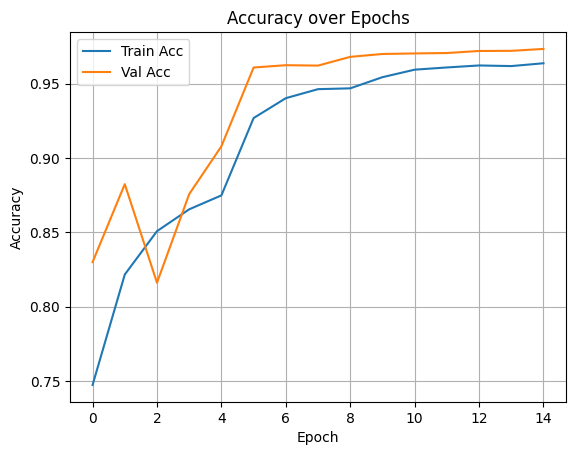

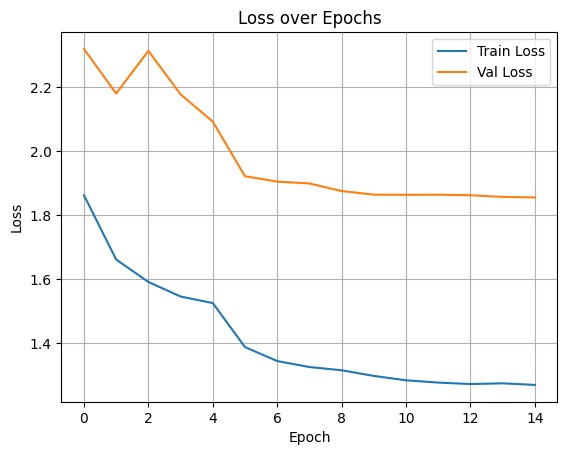

In [22]:
# Plot Accuracy and Loss
plt.figure()
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##### Confusion Matrix

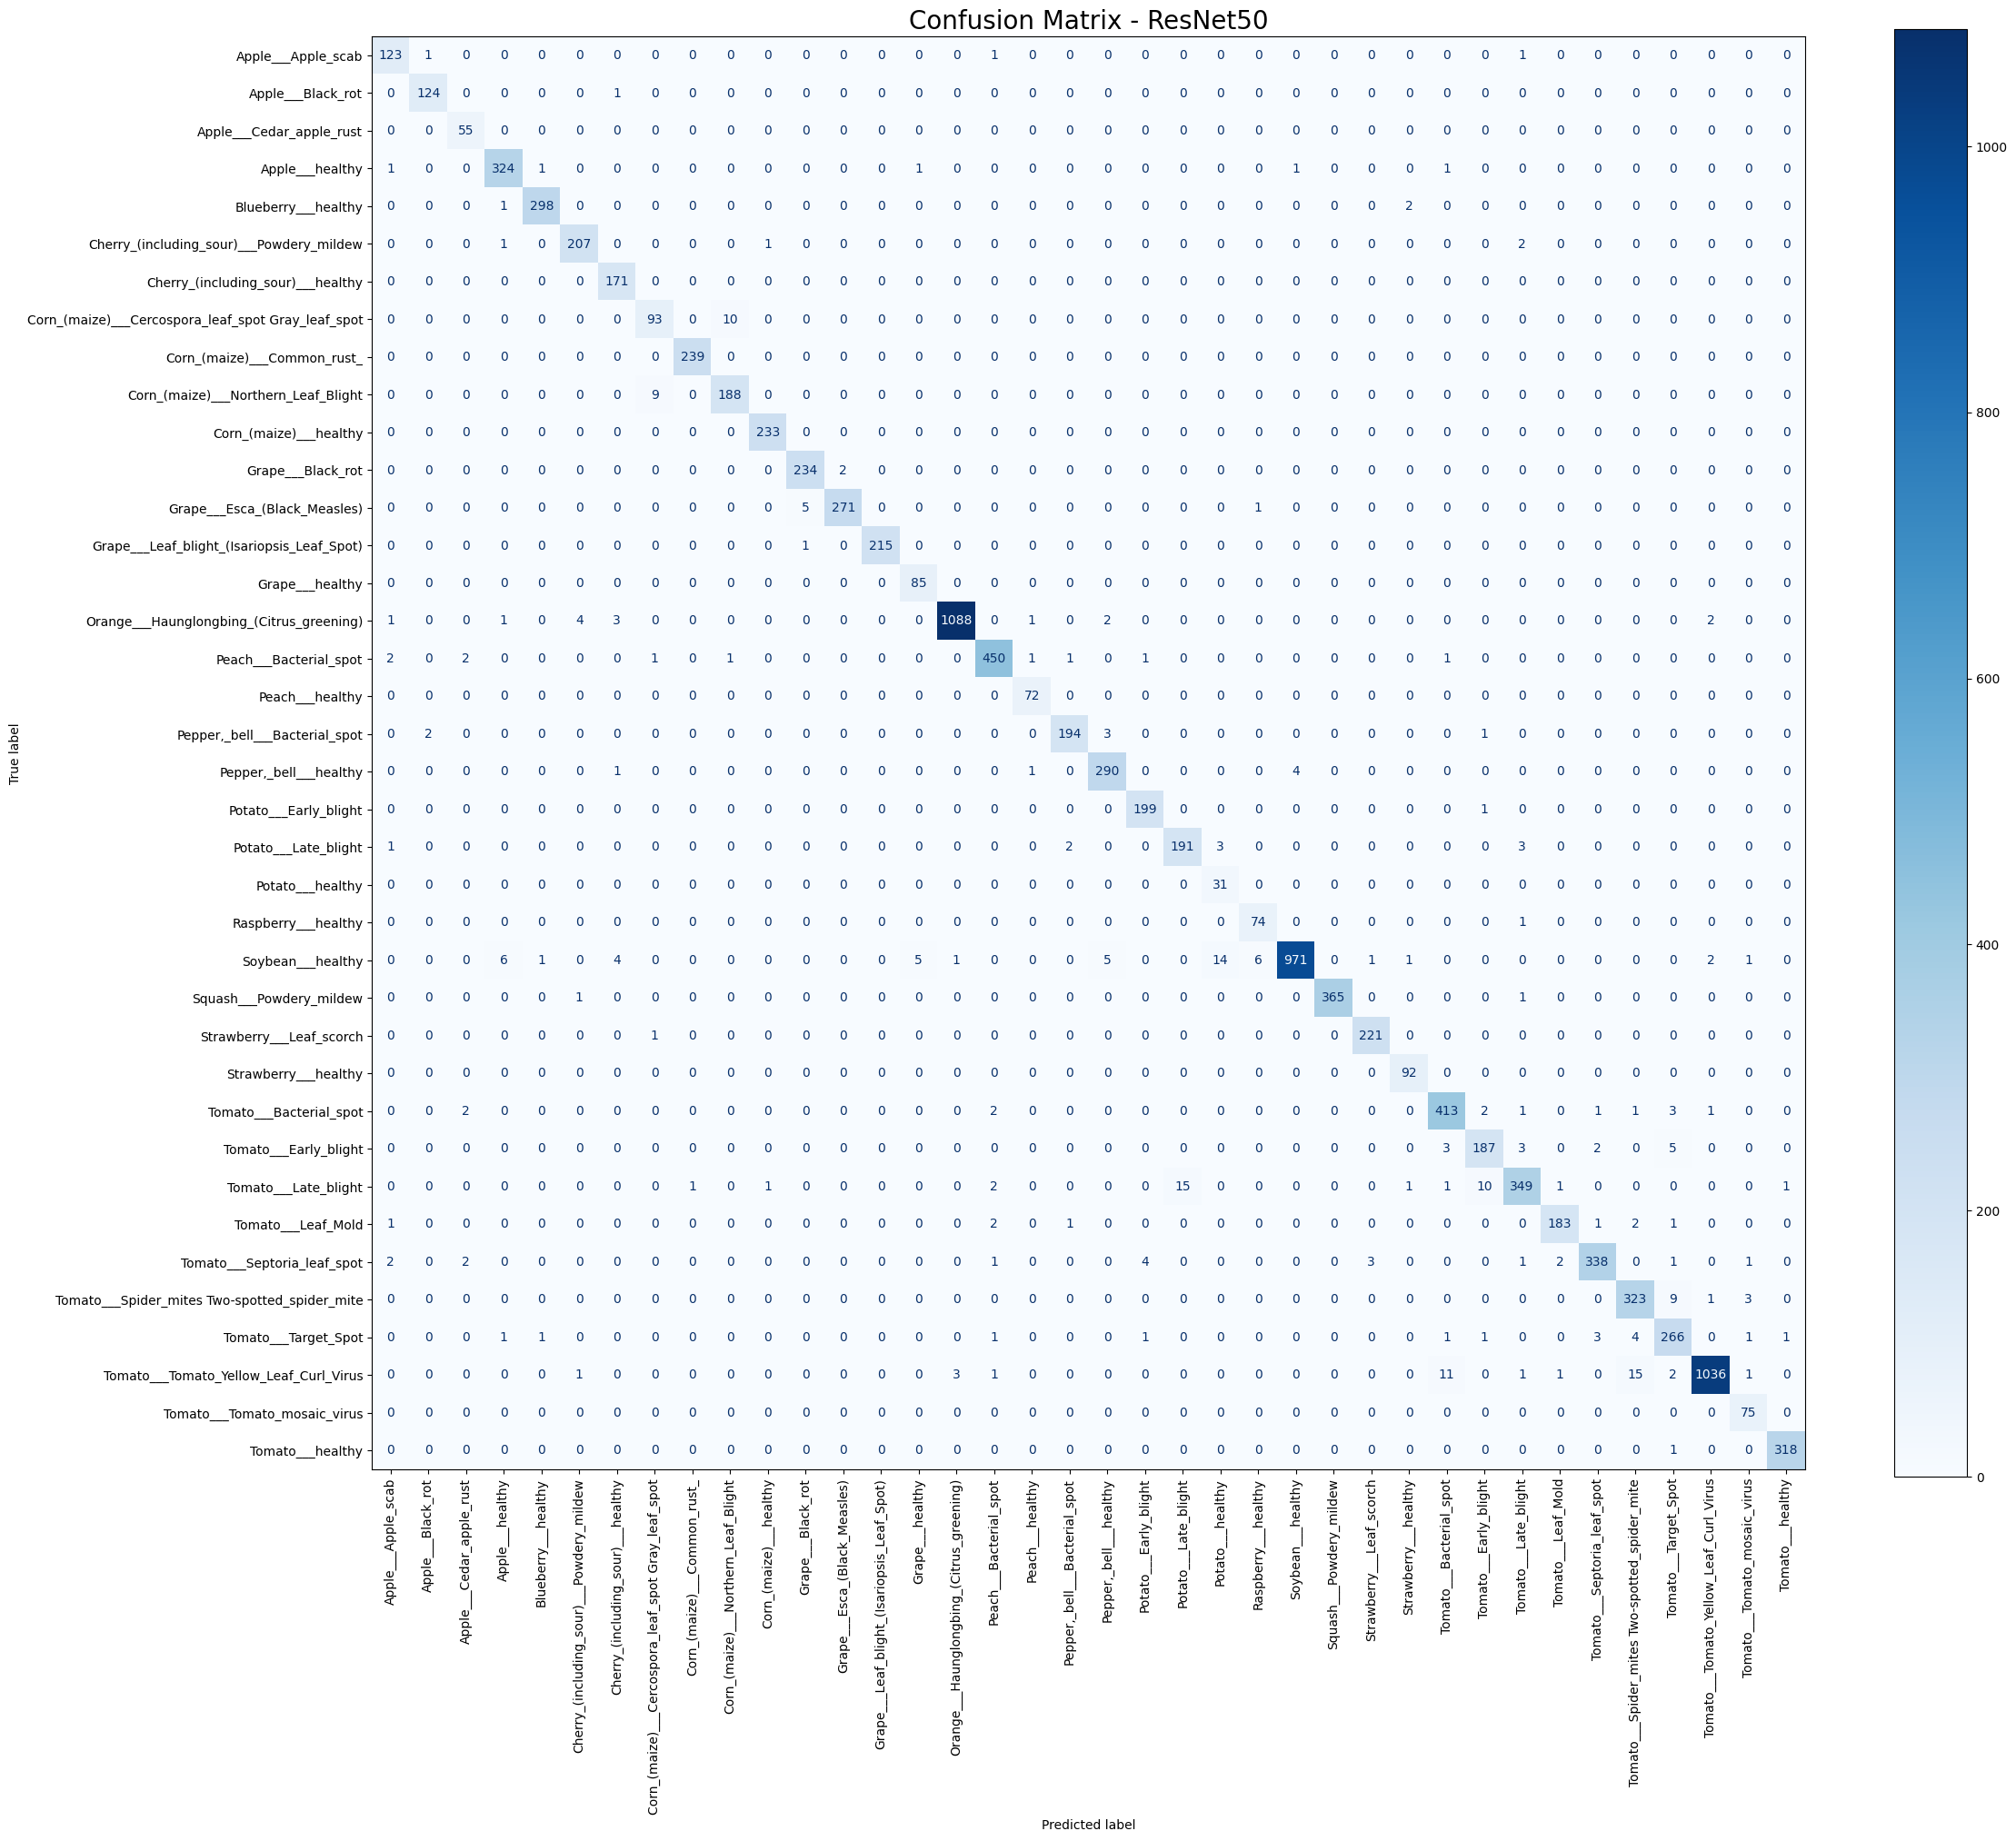

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)


fig, ax = plt.subplots(figsize=(24, 20))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - ResNet50", fontsize=20)
plt.tight_layout()
plt.show()


#### GradCam for ResNet Model

In [33]:
def generate_gradcam_resnet(image_path, model_path, class_names, save_path="resnet50_gradcam.jpg", image_size=224):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Loading model
    model = resnet50(weights=None)
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.5),
        torch.nn.Linear(model.fc.in_features, len(class_names))
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()


    activations, gradients = [], []

    def save_activation(module, input, output):
        activations.append(output)

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer = model.layer4[-1].conv3
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    if not os.path.exists(image_path):
        raise FileNotFoundError(image_path)

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)


    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    print(f"🔍 Predicted: {class_names[pred_class]}")

    model.zero_grad()
    output[0, pred_class].backward()

    if not activations or not gradients:
        raise RuntimeError("Grad-CAM hook failed.")

    act = activations[0].squeeze().cpu().detach().numpy()
    grad = gradients[0].squeeze().cpu().detach().numpy()

    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image_size, image_size))
    cam -= cam.min()
    cam /= cam.max()


    original_img = np.array(image.resize((image_size, image_size)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.5, heatmap, 0.5, 0)


    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print(f"Grad-CAM saved to: {save_path}")


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


🔍 Predicted: Strawberry___Leaf_scorch
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/Resnet1.jpg


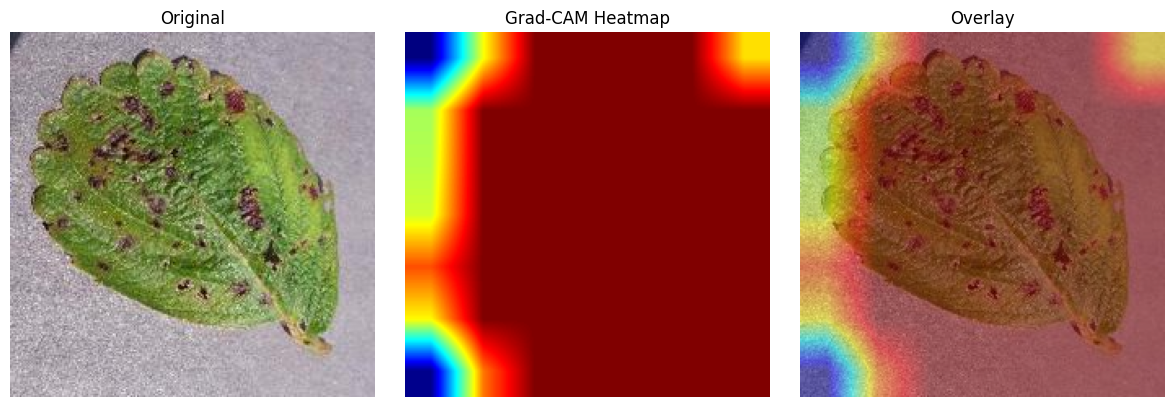

In [45]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/Resnet1.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Strawberry___Leaf_scorch/3a5e8da8-0a36-40c8-8461-5715436b0047___RS_L.Scorch 1484.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_resnet50_model.pth"

generate_gradcam_resnet(image_path, model_path, class_names, save_path)


🔍 Predicted: Grape___Black_rot
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/Resnet2.jpg


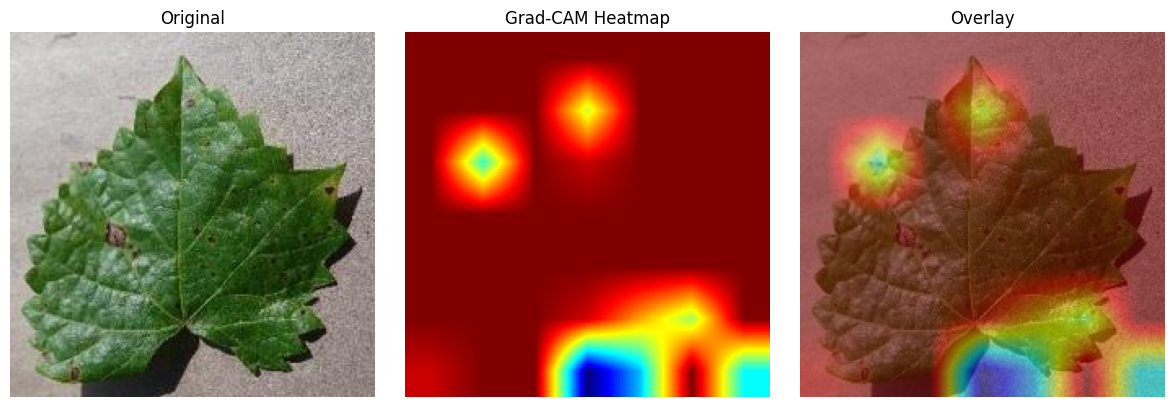

In [48]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/Resnet2.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Grape___Black_rot/b0f6ff75-57b0-4e99-9403-3cee48995e11___FAM_B.Rot 3365.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_resnet50_model.pth"

generate_gradcam_resnet(image_path, model_path, class_names, save_path)

🔍 Predicted: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/Resnet3.jpg


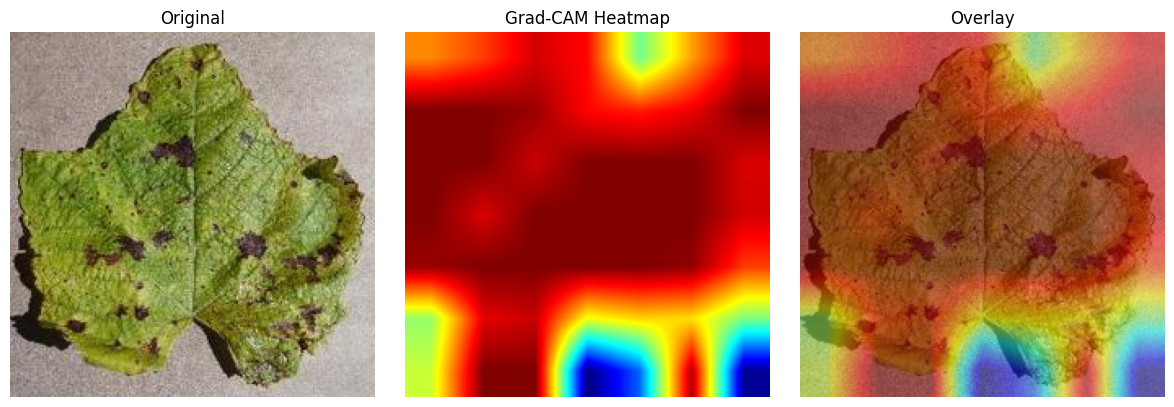

In [50]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/Resnet3.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/8bb44bd5-52f7-416d-98bf-f95ec6ca4d99___FAM_L.Blight 1581.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_resnet50_model.pth"

generate_gradcam_resnet(image_path, model_path, class_names, save_path)